In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pes_bs_utils import parse_energy_cc, parse_energy_hf
from scipy.interpolate import InterpolatedUnivariateSpline as sp

atoms_path="/home/giorgiod/MRCC_interface/Atoms/"
basisSets=['sto-3G', 'sto-6G','3-21G','6-31G*','def2-TZVP','def2-QZVPP','cc-pvtz','aug-cc-pVQZ']
atoms="H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al"
atoms=atoms.split(',')

atoms_mol={'HAl':['H','Al'],'HeMg':['He','Mg'],'LiNa':['Li','Na'],\
           'BeNe':['Be','Ne'],'BF':['B','F'],'CO':['C','O'],'NN':['N','N']}
def energy(bs,targ,ref,hf=False):
    logfile=atoms_path+'{}/{}/{}_at_{}/run.log'.format(bs,targ,targ,ref)
    if hf:
            return parse_energy_hf(logfile)
    return parse_energy_cc(logfile)
def bsc(ref,target):
    return \
    energy('def2-QZVPP',atoms_mol[target][0],atoms_mol[ref][0])\
    +energy('def2-QZVPP',atoms_mol[target][1],atoms_mol[ref][1]) \
    -energy('def2-QZVPP',atoms_mol[target][0],atoms_mol[target][0])\
    -energy('def2-QZVPP',atoms_mol[target][1],atoms_mol[target][1])
bsc('NN','CO')

0.01234583452800564

In [2]:
dt_qzvpp=pd.read_pickle('data_def2_qzvpp')
hfmp2dft=pd.read_pickle('hfmp2dft_def2qzvpp')  #pes at hf, mp2 ,PBE and B3LYP
hfmp2dft[:10]

,calc,distance,energy,mol
0,PBE,1.3,-123.006279,BF
1,PBE,1.4,-123.494394,BF
2,PBE,1.5,-123.842846,BF
3,PBE,1.6,-124.089114,BF
4,PBE,1.7,-124.260711,BF
5,PBE,1.8,-124.379879,BF
6,PBE,1.9,-124.461850,BF
7,PBE,2.0,-124.516687,BF
8,PBE,2.1,-124.551409,BF
9,PBE,2.2,-124.571673,BF


Now we only consider alchemies from NN to CO :: from CO to NN and BF :: from BF to CO <br>
2^nd and 4^th order alchemy VS HF and MP2, true CCSD of the target as a reference.



In [8]:
# for masses reference  https://physics.nist.gov/cgi-bin/Compositions/stand_alone.pl
m_B=10.806
m_C=12.0096
m_N=14.006
m_O=15.999
m_F=18.998

# https://physics.nist.gov/cgi-bin/cuu/Value?u|search_for=physchem_in! ++ https://physics.nist.gov/cgi-bin/cuu/Value?me  
dalton_to_au=  1.660e-27 / 9.109e-31

mu_nn=12766.4683422
mu_nn=m_N/2 *dalton_to_au
mu_co=m_C*m_O/(m_C+m_O)*dalton_to_au
mu_bf=m_B*m_F/(m_B+m_F)*dalton_to_au
lightspeed=137.035999753
planck=6.28318530718
centimeter=188972613.392
def to_cm(k,Mu):
    return (k/Mu)**0.5*centimeter/planck/lightspeed
print(mu_nn,mu_bf,mu_co)

12762.081457898783 12552.657457934376 12501.650854791682


In [3]:
def sppes(scan):
    points=np.linspace(1.3,3.2,20)
    target_pts=np.linspace (1.3,3.2,1901) # points 20 in 1.3-3.2 (1.9bohrs)
    bspline=sp(points,scan)
    return bspline(target_pts)

In [4]:
#frequencies !!! only for linspace of e-3 bohr  !!!
def freq(spline,mol):
    red_masses={'NN':mu_nn,'CO':mu_co,'BF':mu_bf}
    Mu=red_masses[mol]
    min_true=np.argmin(spline)
    k_true=(spline[min_true-1]+spline[min_true+1]-2*spline[min_true])*1.e+6
    return to_cm(k_true,Mu)

In [5]:
def Plot(ax,ref,target):
    target_pts=np.linspace (1.3,3.2,1901)
    spline_ccsd=sppes(dt_qzvpp.query("alchemy==0 &ref==@ref & target==@target").e_ccsd )
    spline_alch2=sppes(dt_qzvpp.query("alchemy==2 &ref==@ref & target==@target").e_alch )-bsc('NN','CO')
    spline_alch4_noc=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target ").e_alch )
    spline_alch4=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target").e_alch )-bsc('NN','CO')
    spline_hf=sppes(hfmp2dft.query("calc=='HF' & mol==@target").energy)
    spline_mp2=sppes(hfmp2dft.query("calc=='MP2' & mol==@target").energy)
    spline_pbe=sppes(hfmp2dft.query("calc=='PBE' & mol==@target").energy)
    spline_b3lyp=sppes(hfmp2dft.query("calc=='B3LYP' & mol==@target").energy)
    
    #
    ax[0].plot(target_pts,spline_ccsd,label='CCSD',color='C0')
    ax[0].plot(target_pts,spline_alch2,label='Alchemy $2^{nd}$ order',color='C1')
    ax[0].plot(target_pts,spline_alch4_noc,':',label='Alchemy $4^{nd}$ order no C',color='C2')
    ax[0].plot(target_pts,spline_alch4,label='Alchemy $4^{th}$ order',color='C3')
    ax[0].plot(target_pts,spline_hf,label="HF",color='C4')
    ax[0].plot(target_pts,spline_mp2,label="MP2",color='C5')
    ax[0].plot(target_pts,spline_pbe,label='PBE',color='C6')
    ax[0].plot(target_pts,spline_b3lyp,label='B3LYP',color='C7')
    
    
    ax[0].set(xlim=(1.8,2.6),\
           ylim=(min(spline_b3lyp)-.005, spline_alch4_noc[np.argmin(spline_ccsd)-300]))
    
    #ax[0].set(xlim=((np.argmin(spline_true))/1000+1.,(np.argmin(spline_true))/1000+1.6),\
    #       ylim=(min(spline_alch2)-.01, spline_alch4_noc[np.argmin(spline_true)-300]+0.01))
   # ax[0].set_title("from {} to {}".format(ref,target))
    
    
    ax[1].bar(0,freq(spline_ccsd,target),color='C0',label='CCSD')
    ax[1].bar(1,freq(spline_alch2,target),color='C1',label='Alchemy $2^{nd}$ order')
    ax[1].bar(2,freq(spline_alch4,target),color='C3',label='Alchemy $4^{th}$ order')
    ax[1].bar(3,freq(spline_hf,target),color='C4',label='HF')
    ax[1].bar(4,freq(spline_mp2,target),color='C5',label='MP2')    
    ax[1].bar(5,freq(spline_pbe,target),color='C6',label='PBE')    
    ax[1].bar(6,freq(spline_b3lyp,target),color='C7',label="B3LYP")    
    
    

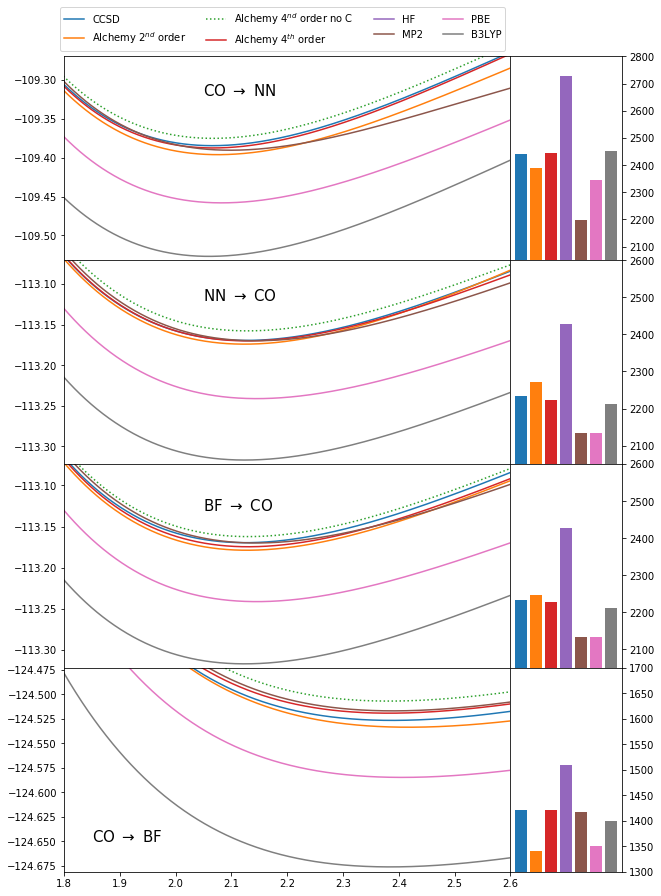

In [9]:
subplspec={'width_ratios' :[4,1], 'wspace':0,'hspace':0}
fig,axs=plt.subplots(4,2,figsize=(10,15),gridspec_kw=subplspec)
for ax in axs.T[:][1]: ax.yaxis.tick_right(),ax.xaxis.set_ticks([])
Plot(axs[0],'CO','NN')
Plot(axs[1],'NN','CO')
Plot(axs[2],'BF','CO')
Plot(axs[3],'CO','BF')
axs[0][0].xaxis.set_ticks([]),axs[1][0].xaxis.set_ticks([]),axs[2][0].xaxis.set_ticks([])

axs[0][1].set(ylim=(2050,2800)),axs[1][1].set(ylim=(2050,2600)),axs[2][1].set(ylim=(2050,2600)),axs[3][1].set(ylim=(1300,1700))

axs[0][0].text(2.05,-109.32, r'CO $\rightarrow$ NN',fontsize=15)
axs[1][0].text(2.05,-113.12, r'NN $\rightarrow$ CO',fontsize=15)
axs[2][0].text(2.05,-113.13, r'BF $\rightarrow$ CO',fontsize=15)
axs[3][0].text(1.85,-124.65, r'CO $\rightarrow$ BF',fontsize=15)

axs[0][0].legend(ncol=4,bbox_to_anchor=(0.1,1.,.9,.2))
#plt.savefig('freq_2.png')

In [9]:
"""subplspec={'width_ratios' :[4,1], 'wspace':0,'hspace':0}
fig,axs=plt.subplots(4,2,figsize=(10,15),gridspec_kw=subplspec)
for ax in axs.T[:][1]: ax.yaxis.tick_right()
Plot(axs[0],'CO','NN')
Plot(axs[1],'BF','NN')
Plot(axs[2],'NN','CO')
Plot(axs[3],'BF','CO')
Plot(axs[4],'CO','BF')
Plot(axs[5],'NN','BF')
plt.savefig('freq_2.png') """

"subplspec={'width_ratios' :[4,1], 'wspace':0,'hspace':0}\nfig,axs=plt.subplots(4,2,figsize=(10,15),gridspec_kw=subplspec)\nfor ax in axs.T[:][1]: ax.yaxis.tick_right()\nPlot(axs[0],'CO','NN')\nPlot(axs[1],'BF','NN')\nPlot(axs[2],'NN','CO')\nPlot(axs[3],'BF','CO')\nPlot(axs[4],'CO','BF')\nPlot(axs[5],'NN','BF')\nplt.savefig('freq_2.png') "

In [ ]:
def Plot(ax,ref,target):
    target_pts=np.linspace (1.3,3.2,1901)
    spline_ccsd=sppes(dt_qzvpp.query("alchemy==0 &ref==@ref & target==@target").e_ccsd )
    spline_alch2=sppes(dt_qzvpp.query("alchemy==2 &ref==@ref & target==@target").e_alch )-bsc('NN','CO')
    spline_alch4_noc=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target ").e_alch )
    spline_alch4=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target").e_alch )-bsc('NN','CO')
    spline_hf=sppes(hfmp2dft.query("calc=='HF' & mol==@target").energy)
    spline_mp2=sppes(hfmp2dft.query("calc=='MP2' & mol==@target").energy)
    spline_pbe=sppes(hfmp2dft.query("calc=='PBE' & mol==@target").energy)
    spline_b3lyp=sppes(hfmp2dft.query("calc=='B3LYP' & mol==@target").energy)